In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/ABRO/"
!ls "drive/My Drive/ABRO/ADNI/"

from IPython.display import clear_output
# !cd "drive/My Drive/ABRO/Atlas/" && unrar e MASKS_MNI2mm.rar

Mounted at /content/drive
AD  CN


In [ ]:
import nibabel as nib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob


width = 80
height = 80
depth = 80
nLabel = 2

fRange1 = slice(6,86)
fRange2 = slice(16,96)
fRange3 = slice(6,86)

In [ ]:
# G=glob.glob(data_path,'Atlas/*.nii')
# Bin_reg_masks=np.zeros((80,80,80,len(G)))
# idx=0
# for g in G:
#     n1_img = nib.load(g)
#     tmp=np.array(n1_img.get_data())
#     tmp2=tmp[fRange1,fRange2,fRange3]>0
#     Bin_reg_masks[...,idx]=tmp2
#     idx+=1
#     print('Brain region',idx,'loaded.')

# clear_output()

def norm(A):
       return A#(A-np.amin(A))/(np.amax(A)-np.amin(A))

_data = []
_labels = []
G=glob.glob(data_path+'ADNI/AD/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(1)


G=glob.glob(data_path+'ADNI/CN/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(0)


clear_output()
_data = np.array(_data)#[...,np.newaxis]
_labels = np.array(_labels)

print('_data.shape=>', _data.shape)
print('_labels.shape=>', _labels.shape)

_data.shape=> (145, 80, 80, 80)
_labels.shape=> (145,)


In [ ]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical

# oh_labels = to_categorical(_labels)

x_train, x_test, y_train, y_test  = train_test_split(_data, _labels,
                              train_size=.8,random_state=123,shuffle=True)


print('x_train.shape=>', x_train.shape)
print('y_train.shape=>', y_train.shape)
print('x_test.shape=>', x_test.shape)
print('y_test.shape=>', y_test.shape)



x_train.shape=> (116, 80, 80, 80)
y_train.shape=> (116,)
x_test.shape=> (29, 80, 80, 80)
y_test.shape=> (29,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

batch_size = 8
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the MRI scan is: (80, 80, 80, 1)


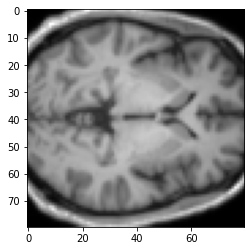

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

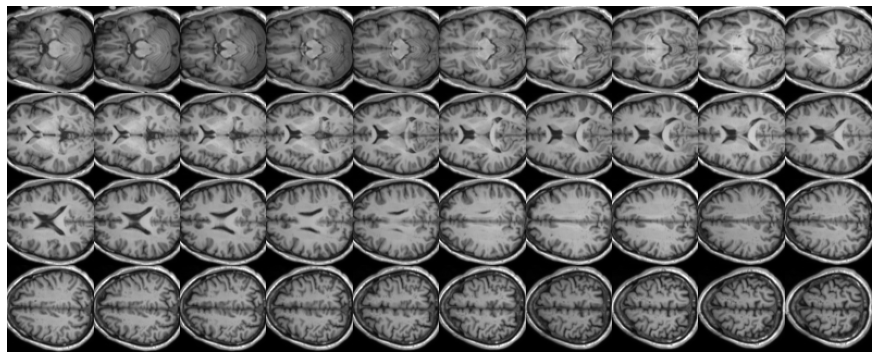

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the MRI scan.
plot_slices(4, 10, 80, 80, image[:, :, ::2])


In [ ]:
def get_model(width=80, height=80, depth=80):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    x = (inputs)
    x = layers.Dropout(0.05)(x)
    x = layers.Conv3D(filters=8, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    # x = layers.MaxPool3D(pool_size=2)(x)
    # x = layers.BatchNormalization()(x)

    # x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)

    x = layers.Dense(units=512, activation="sigmoid")(x)
    x = layers.Dropout(0.05)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=80, height=80, depth=80)
# model.summary()

In [ ]:
# Compile model.
# initial_learning_rate = 0.001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=1000, decay_rate=0.95, staircase=True
# )
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    data_path+"chkp/3d_MRI_classification_2.h5", save_best_only=True
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 20
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)


Epoch 1/20
15/15 - 3s - loss: 1.1924 - acc: 0.5603 - val_loss: 0.8717 - val_acc: 0.5862
Epoch 2/20
15/15 - 3s - loss: 0.6291 - acc: 0.6466 - val_loss: 0.7703 - val_acc: 0.5862
Epoch 3/20
15/15 - 3s - loss: 0.5777 - acc: 0.7241 - val_loss: 0.7101 - val_acc: 0.6207
Epoch 4/20
15/15 - 2s - loss: 0.5963 - acc: 0.6638 - val_loss: 0.7528 - val_acc: 0.6552
Epoch 5/20
15/15 - 2s - loss: 0.5515 - acc: 0.7155 - val_loss: 0.8047 - val_acc: 0.7241
Epoch 6/20
15/15 - 3s - loss: 0.4213 - acc: 0.8190 - val_loss: 0.6551 - val_acc: 0.6897
Epoch 7/20
15/15 - 2s - loss: 0.3856 - acc: 0.8276 - val_loss: 0.5606 - val_acc: 0.7586
Epoch 8/20
15/15 - 2s - loss: 0.2575 - acc: 0.9310 - val_loss: 0.6927 - val_acc: 0.6552
Epoch 9/20
15/15 - 2s - loss: 0.2204 - acc: 0.9310 - val_loss: 0.4931 - val_acc: 0.7241
Epoch 10/20
15/15 - 2s - loss: 0.1446 - acc: 0.9655 - val_loss: 0.5922 - val_acc: 0.6897
Epoch 11/20
15/15 - 3s - loss: 0.1163 - acc: 0.9741 - val_loss: 0.4462 - val_acc: 0.7241
Epoch 12/20
15/15 - 2s - loss:

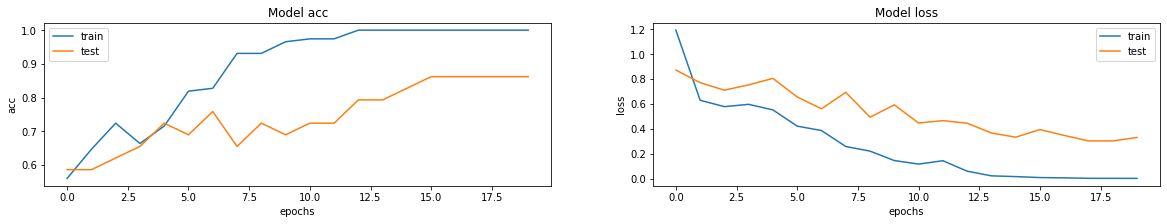

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "test"])


In [ ]:

# Load best weights.
model.load_weights(data_path+"chkp/3d_MRI_classification_2.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
# prediction = softmax(prediction)  
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
print('Real label is =>',class_names[y_test[0]])
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((score), name)
    )


Real label is => abnormal
This model is 0.01 percent confident that MRI scan is normal
This model is 0.99 percent confident that MRI scan is abnormal
